In [1]:
import itertools
import numpy as np
import pandas as pd
import MDAnalysis as mda
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import pyemma
from pyemma.coordinates import source
from pyemma.util.contexts import settings
from pyemma.coordinates.data.featurization.misc import GroupCOMFeature
import os
import sys
import MDAnalysis as mda
from tqdm import tqdm
sys.path.insert(0, '../')
import featurize.featurize_v3 as featurize
import featurize.caller_v3 as caller


In [2]:
import glob

getting paths

In [3]:

path = '../../test/'
files_adaptive = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.xtc')]

for file in files_adaptive:
    print(file)


../../test/t1.xtc
../../test/t2.xtc
../../test/t3.xtc


In [4]:
mda_list = []
for item in files_adaptive:
    u_ = mda.Universe('../../test/gro.gro', item)
    mda_list.append(u_)
    print(item)

../../test/t1.xtc
../../test/t2.xtc
../../test/t3.xtc


In [5]:
# Initialize mdtraj topology and mdanalysis
traj = md.load('../../test/t1.xtc', top='../../test/gro.gro')
u = mda.Universe('../../test/gro.gro', '../../test/t1.xtc')
topfile = '../../test/gro.gro'

In [6]:
def load_and_combine(prefix, extension="npy"):
    saved_files = glob.glob(f'{prefix}_*.{extension}')
    print(saved_files)
    print(prefix)
    combined_results = []
    for file in saved_files:
        data = np.load(file)
        combined_results.append(data)
    return combined_results

# Tilt Angle


In [7]:
helix_ranges = [(6, 15), (20, 36)] 

In [6]:
helix = featurize.HelixAnalysis(topfile)

In [7]:
angles = helix.analyze_multiple_files(files_adaptive, helix_ranges)

<Universe with 234791 atoms>
<XTCReader ../../test/t1.xtc with 11 frames of 234791 atoms>
<XTCReader ../../test/t1.xtc with 11 frames of 234791 atoms>
<XTCReader ../../test/t1.xtc with 11 frames of 234791 atoms>
<XTCReader ../../test/t1.xtc with 11 frames of 234791 atoms>
<XTCReader ../../test/t1.xtc with 11 frames of 234791 atoms>
<XTCReader ../../test/t1.xtc with 11 frames of 234791 atoms>
<XTCReader ../../test/t1.xtc with 11 frames of 234791 atoms>
<XTCReader ../../test/t1.xtc with 11 frames of 234791 atoms>
<XTCReader ../../test/t1.xtc with 11 frames of 234791 atoms>
<XTCReader ../../test/t1.xtc with 11 frames of 234791 atoms>
<XTCReader ../../test/t1.xtc with 11 frames of 234791 atoms>
<Universe with 234791 atoms>
<XTCReader ../../test/t2.xtc with 19 frames of 234791 atoms>
<XTCReader ../../test/t2.xtc with 19 frames of 234791 atoms>
<XTCReader ../../test/t2.xtc with 19 frames of 234791 atoms>
<XTCReader ../../test/t2.xtc with 19 frames of 234791 atoms>
<XTCReader ../../test/t2.xt

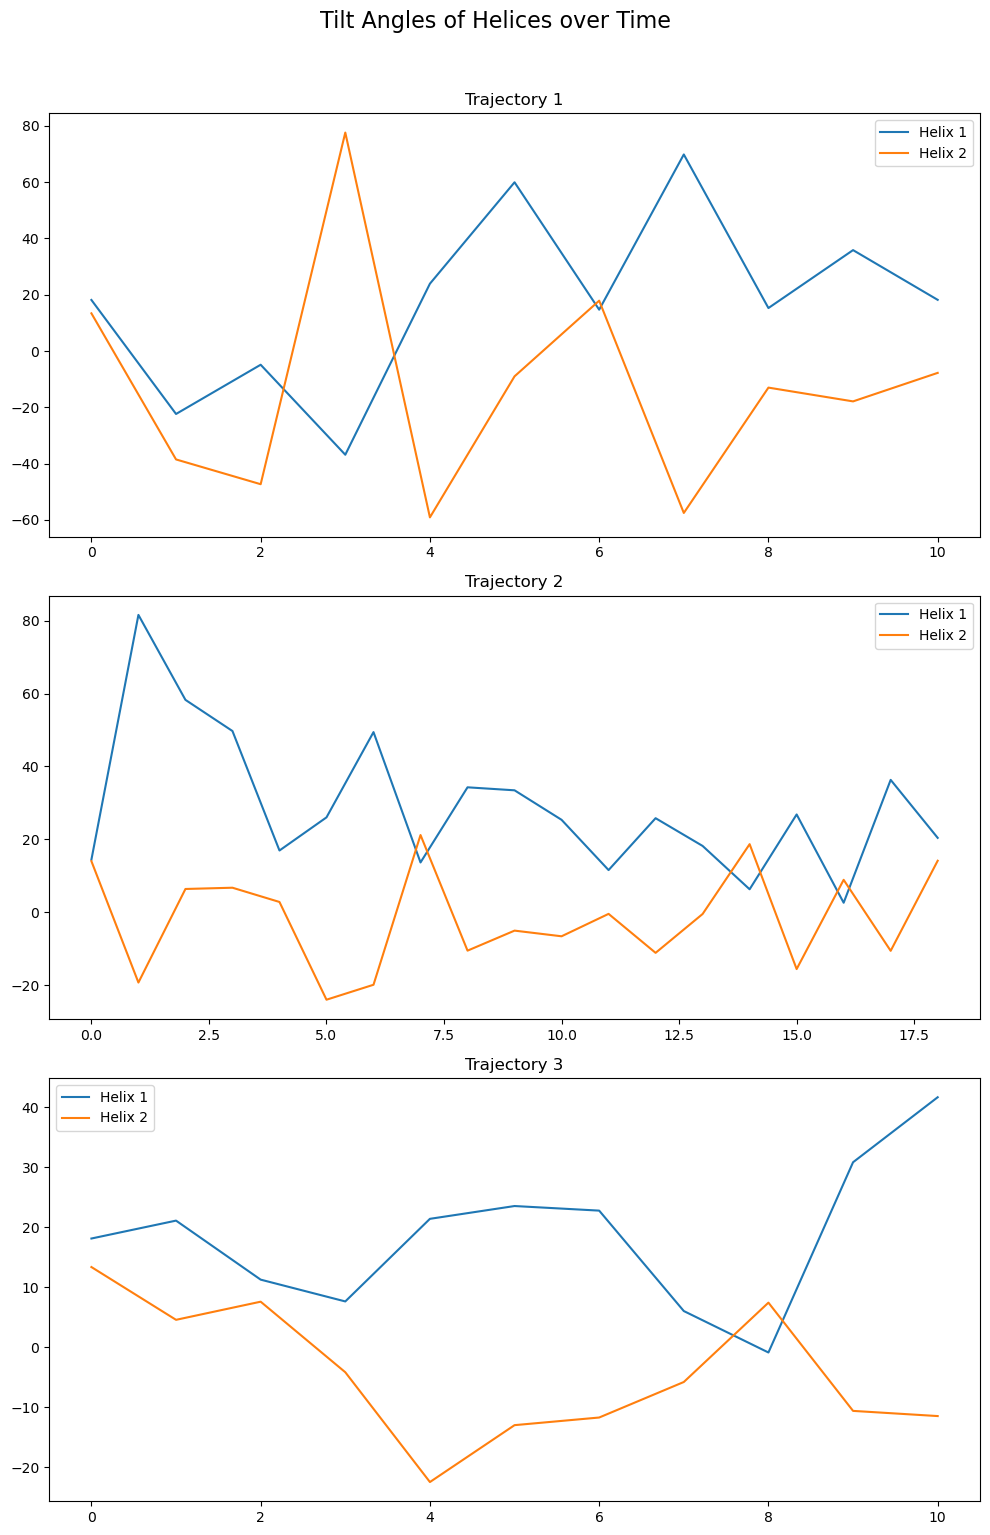

In [15]:

def plot_tilt_angles(trajectories_list):
    """
    Plots the tilt angles for any number of trajectories.

    Parameters:
    - trajectories_list: List of trajectories where each trajectory is a list of tuples (angle_helix1, angle_helix2).
    """
    num_trajectories = len(trajectories_list)
    
    # Create subplots for each trajectory
    fig, axes = plt.subplots(num_trajectories, 1, figsize=(10, 5*num_trajectories))
    fig.suptitle('Tilt Angles of Helices over Time', fontsize=16, y=1.02)
    
    # If there's only one trajectory, make axes a list for consistent indexing
    if num_trajectories == 1:
        axes = [axes]
    
    for i, trajectory in enumerate(trajectories_list):
        angles_helix1 = [angle[0] for angle in trajectory]
        angles_helix2 = [angle[1] for angle in trajectory]

        axes[i].plot(angles_helix1, label='Helix 1')
        axes[i].plot(angles_helix2, label='Helix 2')
        axes[i].set_title(f'Trajectory {i+1}')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

plot_tilt_angles(angles)


In [16]:
caller.save_reader(angles, 'feats_prod/angles_helix')

In [17]:
arr1 = [pyemma.coordinates.load(f'feats_prod/angles_helix_{i:03d}.npy') for i in range(3)]

# Min dist

doing some dev 10/3

In [8]:
dist_obj = featurize.dist()

In [9]:
dist_obj = featurize.dist()
save_prefix = 'feats_prod/min_dist'
all_min_distances = dist_obj.min_dist(mda_list, save_prefix)

Processing ../../test/t3.xtc: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.41it/s]


In [10]:
combined_min = load_and_combine(save_prefix)

['feats_prod/min_dist_t1_min_dist.npy', 'feats_prod/min_dist_t2_min_dist.npy', 'feats_prod/min_dist_t3_min_dist.npy']
feats_prod/min_dist


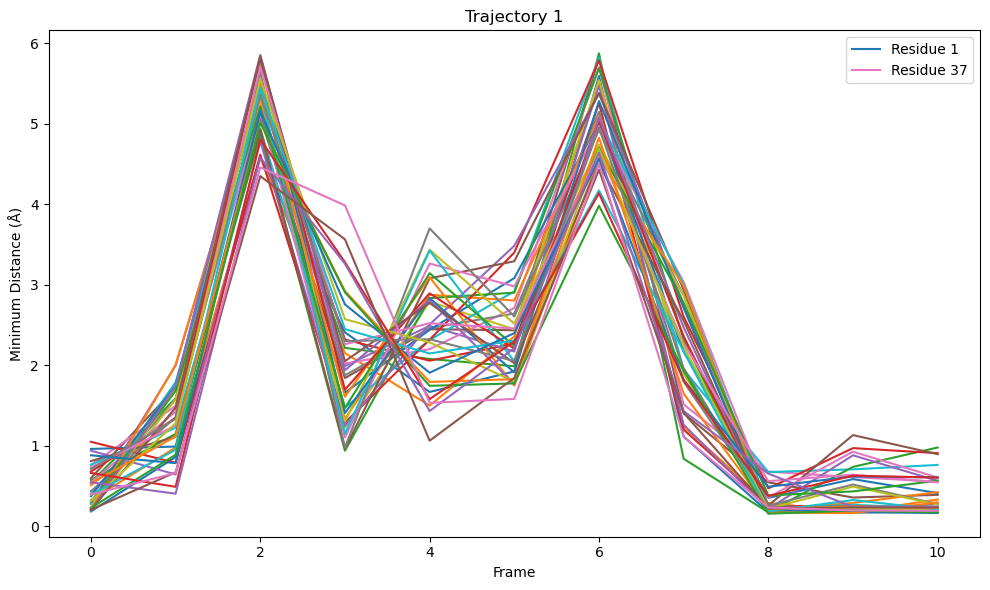

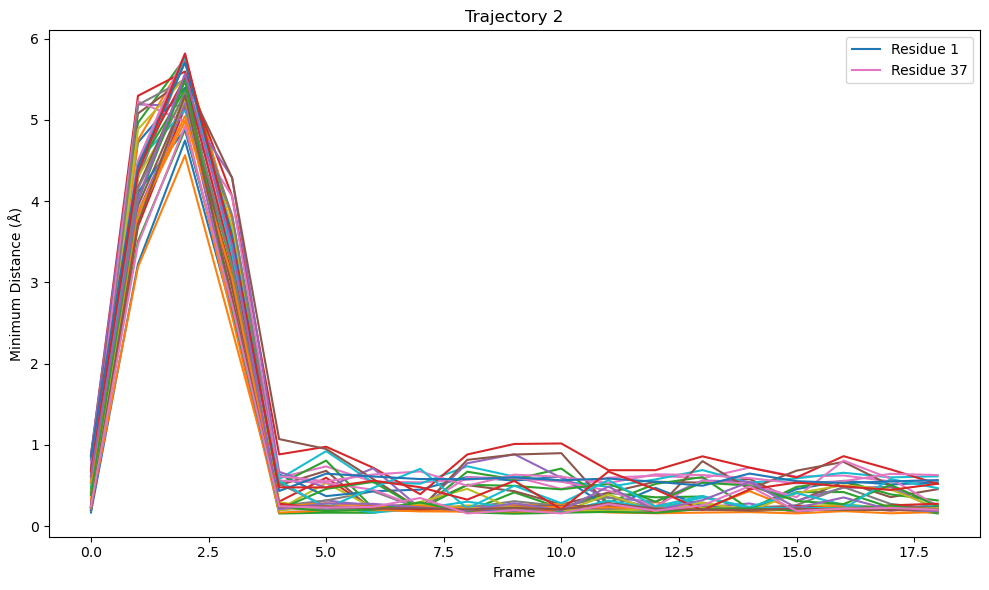

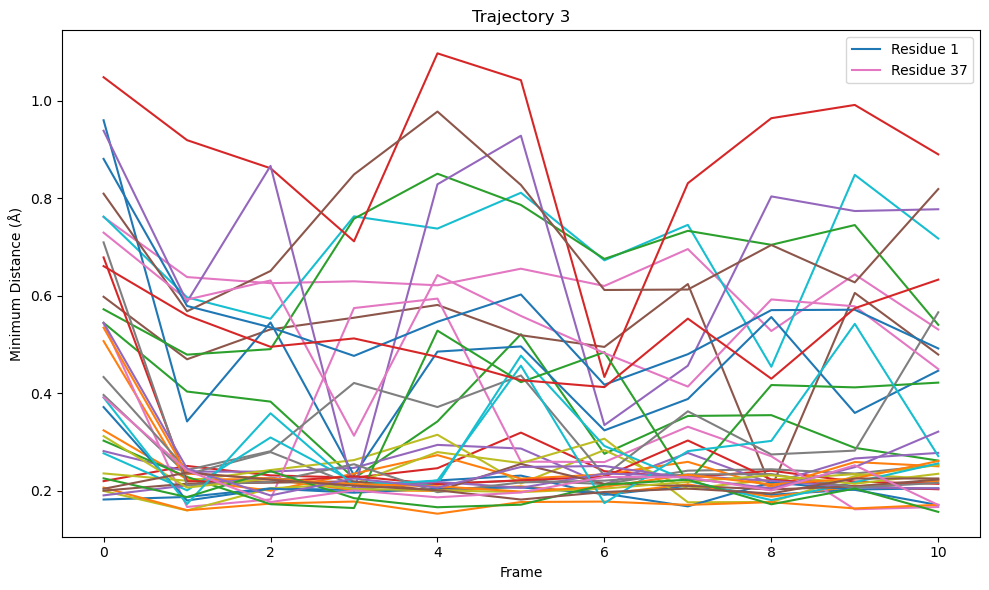

In [20]:
import matplotlib.pyplot as plt

# Loop through each trajectory's data and plot it
for i, traj_data in enumerate(all_min_distances):
    plt.figure(figsize=(10, 6))
    
    # Plot the distances for each residue
    for j in range(traj_data.shape[1]):
        plt.plot(traj_data[:, j], label=f'Residue {j+1}' if j in [0, 36] else "")
    
    plt.title(f'Trajectory {i+1}')
    plt.xlabel('Frame')
    plt.ylabel('Minimum Distance (Å)')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


# Ca-Ca Dists

In [24]:
dist_obj

In [38]:
c1 = traj.topology.select('name CA and residue >= 0 and residue <= 10')
c2 = traj.topology.select('name CA and residue >= 2 and residue <= 30')

In [43]:
# Define a function to select CA atoms with a skip of 3 residues
def select_ca_with_skip(topology, start_residue, end_residue, skip):
    residues = range(start_residue, end_residue + 1, skip)
    ca_atoms = []
    for residue in residues:
        ca_atoms.extend(topology.select(f'name CA and residue == {residue}'))
    return ca_atoms

# Use the function to select CA atoms for residues 1-300 and 301-600 with a skip of 3
c1 = select_ca_with_skip(traj.topology, 0, 20, 3)
c2 = select_ca_with_skip(traj.topology, 20, 30, 3)

In [113]:
dist_ca = dist_obj.compute_ca_dist(files_adaptive, topfile, c1=c1, c2=c2, chunk_size=200)

Processing trajectories:   0%|                                                                                                                                                                                             | 0/3 [00:00<?, ?it/s]
Processing ../test/t1.xtc: 0it [00:00, ?it/s]
Processing ../test/t1.xtc: 1it [00:04,  4.33s/it]
Processing trajectories:  33%|████████████████████████████████████████████████████████████▎                                                                                                                        | 1/3 [00:04<00:08,  4.34s/it]
Processing ../test/t2.xtc: 0it [00:00, ?it/s]
Processing ../test/t2.xtc: 1it [00:04,  4.88s/it]
Processing trajectories:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 2/3 [00:09<00:04,  4.66s/it]
Processing ../test/t3.xtc: 0it [00:00, ?it/s]
Processing ../test/t3.xtc: 1it [00:0

In [29]:
caller.save_reader(dist_ca, 'feats_prod/ca_ca_dist')
arr_ca = [pyemma.coordinates.load(f'feats_prod/ca_ca_dist_{i:03d}.npy') for i in range(3)]

#  Now contacts

dev 10/3


In [12]:
protein_selection ='protein'
lipid_selection = 'resname POPC DOPE SAPI'

In [13]:
contact_obj = featurize.cont()

In [14]:
all_contacts = contact_obj.calculate_contacts(mda_list, protein_selection, lipid_selection, save_prefix='feats_prod/contacts')

In [15]:
s = load_and_combine('feats_prod/contacts')

['feats_prod/contacts_t1_contacts.npy', 'feats_prod/contacts_t2_contacts.npy', 'feats_prod/contacts_t3_contacts.npy']
feats_prod/contacts


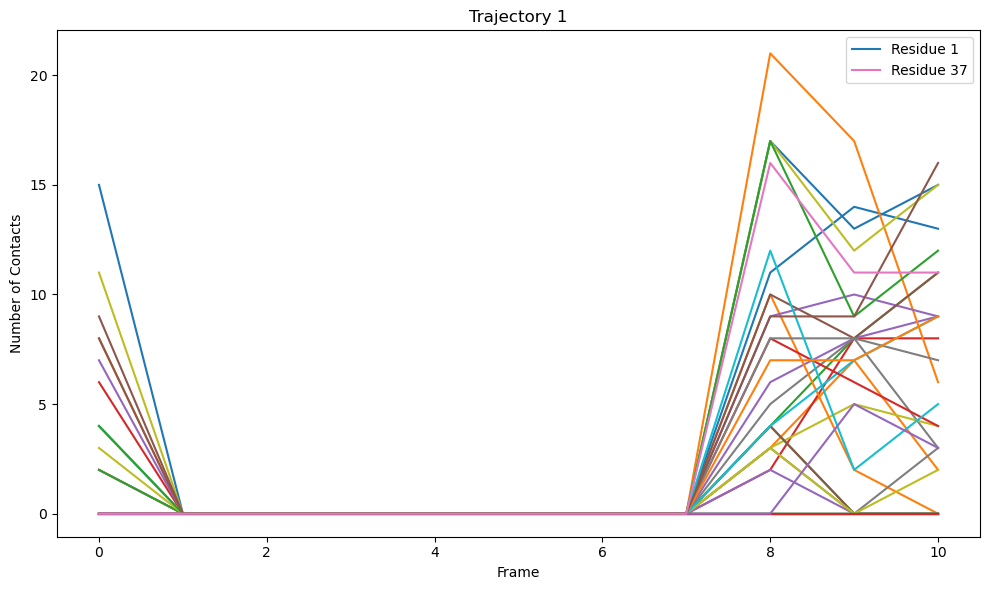

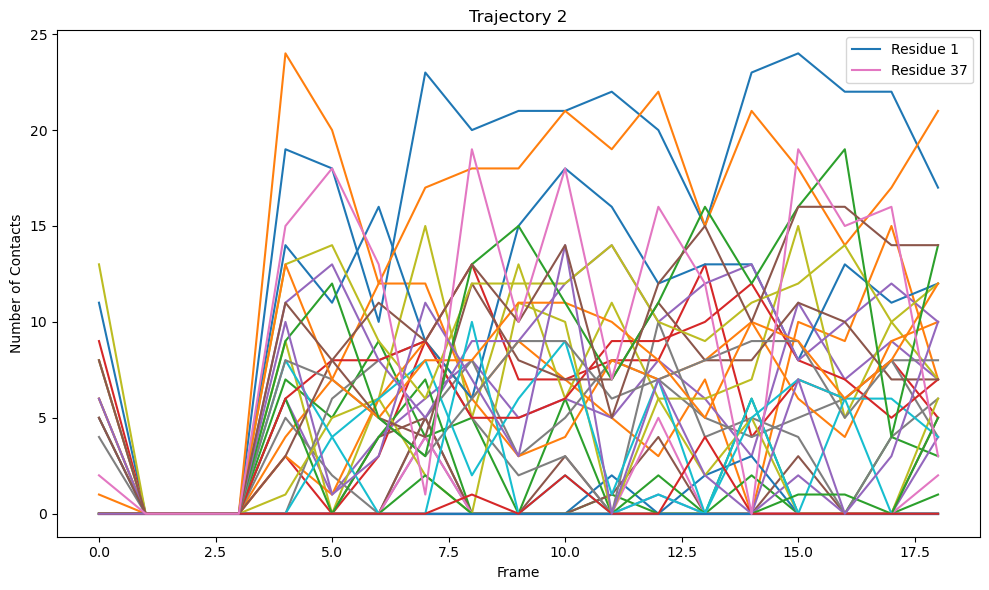

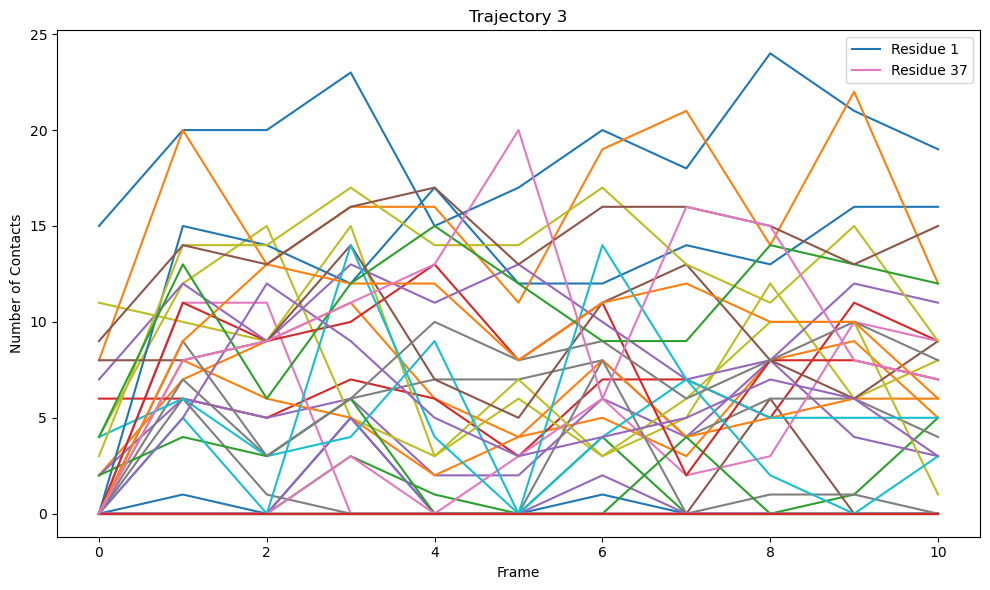

In [17]:
# Loop through each trajectory's data and plot it
for i, traj_data in enumerate(all_contacts):
    plt.figure(figsize=(10, 6))
    
    # Plot the contacts for each residue
    for j in range(traj_data.shape[1]):  # Here, we loop over residues instead of frames
        plt.plot(traj_data[:, j], label=f'Residue {j+1}' if j in [0, 36] else "")
    
    plt.title(f'Trajectory {i+1}')
    plt.xlabel('Frame')
    plt.ylabel('Number of Contacts')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


# Now for backbone (PyEMMA)

In [8]:
distances_feat = pyemma.coordinates.featurizer('10.gro')
distances_feat.add_distances(
    distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=5), periodic=True)


In [9]:
distances_data = pyemma.coordinates.load(files, features=distances_feat)


Obtaining file info:   0%|                                                                                 | 0…

getting output of FeatureReader:   0%|                                                                     | 0…

In [17]:
np.shape(distances_data[1])

(10001, 5994)

# and Torisons

In [14]:
torsions_feat = pyemma.coordinates.featurizer('10.gro')
torsions_feat.add_backbone_torsions(cossin=True, periodic=True)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)


Obtaining file info:   0%|                                                                                 | 0…

getting output of FeatureReader:   0%|                                                                     | 0…

In [8]:

feat = pyemma.coordinates.featurizer('10.gro')

# Define atom pairs for the distances
ca_1_14 = feat.select('name CA and resid 0 to 13')  # Note: PyEMMA also uses 0-based indexing
ca_21_36 = feat.select('name CA and resid 20 to 35')

pairs = np.array([(i, j) for i in ca_1_14 for j in ca_21_36])


In [10]:
feat.add_distances(pairs, periodic=True)

In [11]:
pairs_data = pyemma.coordinates.load(files, features=feat)

Obtaining file info:   0%|                               | 0/11 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                   | 0/11 [00:00<?, ?it/s]

In [24]:
for index, (i, j) in enumerate(pairs):
    print(f"Index {index}: Atom pair ({i}, {j})")


Index 0: Atom pair (8, 326)
Index 1: Atom pair (8, 345)
Index 2: Atom pair (8, 369)
Index 3: Atom pair (8, 384)
Index 4: Atom pair (8, 403)
Index 5: Atom pair (8, 419)
Index 6: Atom pair (8, 438)
Index 7: Atom pair (8, 445)
Index 8: Atom pair (8, 461)
Index 9: Atom pair (8, 480)
Index 10: Atom pair (8, 497)
Index 11: Atom pair (8, 514)
Index 12: Atom pair (8, 533)
Index 13: Atom pair (8, 555)
Index 14: Atom pair (8, 569)
Index 15: Atom pair (8, 586)
Index 16: Atom pair (28, 326)
Index 17: Atom pair (28, 345)
Index 18: Atom pair (28, 369)
Index 19: Atom pair (28, 384)
Index 20: Atom pair (28, 403)
Index 21: Atom pair (28, 419)
Index 22: Atom pair (28, 438)
Index 23: Atom pair (28, 445)
Index 24: Atom pair (28, 461)
Index 25: Atom pair (28, 480)
Index 26: Atom pair (28, 497)
Index 27: Atom pair (28, 514)
Index 28: Atom pair (28, 533)
Index 29: Atom pair (28, 555)
Index 30: Atom pair (28, 569)
Index 31: Atom pair (28, 586)
Index 32: Atom pair (45, 326)
Index 33: Atom pair (45, 345)
Index 

In [13]:
caller.save_reader(pairs_data, 'feats_prod/ca_pairs')

In [15]:
caller.save_reader(torsions_data, 'feats_prod/tor')

In [16]:
caller.save_reader(distances_data, 'feats_prod/ca_ca')

# coordination analysis


In [58]:
coord_analysis = feat_.cont()
coord_analysis.run_coord

<bound method cont.run_coord of <featurize.featurize_v2.cont object at 0x14b350f06a30>>

In [59]:
# Define lipid and protein selections
lipid_selection = '(resname POPC DOPE SAPI and name P)'
prot_selections = [f"(resid {i}) and (not backbone)" for i in range(1, 36)]

# Run analysis for each trajectory and each protein selection
results_coord = []
for universe in mda_list:
    for prot_sel in prot_selections:
        result = coord_analysis.run_coord(universe, universe.select_atoms(prot_sel), universe.select_atoms(lipid_selection))
        results_coord.append(result)

In [60]:
# Combine the data from each dataset for each trajectory
result_list3 = []
for i in range(len(files)):
    arr3 = combine(results_coord)[i]
    result_list3.append(arr3)

(1, 1, 35, 34)
(1, 1, 35, 26)
(1, 1, 35, 30)
(1, 1, 35, 34)
(1, 1, 35, 26)
(1, 1, 35, 30)
(1, 1, 35, 34)
(1, 1, 35, 26)
(1, 1, 35, 30)


/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [49]:
caller.save_reader(result_list3, 'feats/coord')

In [65]:
np.shape(result_list3[0])

(1001, 35)

# penetration depth

In [17]:
dist_analysis = featurize.dist()

In [18]:
protein_ca_indices = traj.topology.select('name CA and protein')
lipid_p_indices = traj.topology.select('name P and resname POPC')

In [19]:
save_prefix = 'feats_prod/penetration_depth'
chunk_size = 2000
penetration_depths = dist_analysis.compute_penetration_depth(files_adaptive, topfile, protein_ca_indices, lipid_p_indices, chunk_size, save_prefix)

Processing trajectory files:   0%|                                                                                                                                                                                         | 0/3 [00:00<?, ?it/s]
Processing chunks in ../../test/t1.xtc: 0it [00:00, ?it/s]
Processing chunks in ../../test/t1.xtc: 1it [00:05,  5.52s/it]
Processing trajectory files:  33%|███████████████████████████████████████████████████████████                                                                                                                      | 1/3 [00:05<00:11,  5.53s/it]
Processing chunks in ../../test/t2.xtc: 0it [00:00, ?it/s]
Processing chunks in ../../test/t2.xtc: 1it [00:05,  5.42s/it]
Processing trajectory files:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 2/3 [00:10<00:05,  5.47s/it]
Processing chunks in ../../tes

In [20]:
t = load_and_combine(save_prefix)

['feats_prod/penetration_depth_t1_chunk_000.npy', 'feats_prod/penetration_depth_t2_chunk_000.npy', 'feats_prod/penetration_depth_t3_chunk_000.npy']
feats_prod/penetration_depth
